In [1]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import get_lagplot, compute_dRSA
from general_utils.regression import lagged_linear_regression
from neural_utils.utils import load_monkey_data, load_stimuli_models, random_trials_per_rep, min_max_normalization, extract_fixation_responses_sing_trial, extract_fixation_responses_sing_stim, extract_all_fixation_responses

In [2]:
monkey_name = "venus"
month = 'sep'
day = 20
resolution_Hz = 100
npx = True
imec_n = 0
normalization = "min_max"
model_name = "dgIIE"
day = str(day)
neural_data, gaze_data = load_monkey_data(paths, monkey_name, day, month, resolution_Hz, npx=npx, imec_n=imec_n)
# normalizes them 
if normalization == "min_max":
    n_norm = min_max_normalization(neural_data)
# ADD zscore? robust?
elif normalization == None:
    n_norm = delete_empty_keys(neural_data)

# loads and upsamples the model 
all_models = load_stimuli_models(paths, model_name, n_norm.keys(), resolution_Hz)

# extract_fixation_responses(n_norm, gaze_data, all_models, n_timepts_bef, n_timepts_aft, foreperiod_len_timepts=30)

In [5]:
neural_data_fix, gaze_data_fix, model_data_fix = extract_all_fixation_responses(n_norm, gaze_data, all_models, 10, 40, stack=1)
#(n_norm, gaze_data, all_models, n_timepts_bef, n_timepts_aft, foreperiod_len_timepts=30, stack=0)

In [6]:
neural_data_fix.shape

(383, 50, 734)

In [7]:
# from neural_utils.utils import face_fixations
# tot_face_fixation, tot_occluded_face_fixation, tot_non_face_fixation, tot_rep_face_fixation = face_fixations(paths, monkey_name, range(19, 25), month, npx, imec_n, resolution_Hz, 5, 20, 30, "human_face_detection", normalization)
# tot_face_fixation.shape

In [13]:
mod = neural_data_fix[0:20, :,:]
neu = neural_data_fix[330:350, :,:]
lr_list = lagged_linear_regression(mod, neu, regression_type='lr', cv_type='kf', n_splits=5, alpha=1.0, max_lag=10)
lp = get_lagplot(compute_dRSA(neu[:,:,:100], mod[:,:,:100], metric_RDM = "euclidean"), max_lag=10)

10

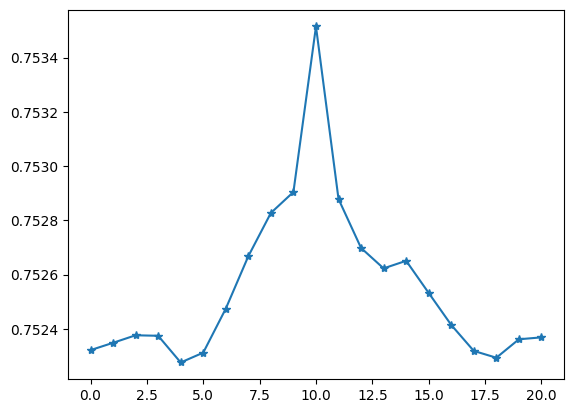

In [25]:
plt.plot(lr_list, marker="*")
#plt.plot(np.sqrt(np.abs(lp)) +0.6, marker="o")
np.argmax(lr_list)